<a href="https://colab.research.google.com/github/sheladiya2010-afk/Teleco_Customer_Churn/blob/main/HR_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


import shap
import joblib

df = pd.read_csv('HR-Employee-Attrition.csv')
print('Rows, cols:', df.shape)
df.head()

Rows, cols: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [47]:
# ----------------------
# Config
# ----------------------
DATA_PATH = Path('HR-Employee-Attrition.csv')
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

In [48]:
# ----------------------
# Load data
# ----------------------
print('Loading data from', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Rows, cols:', df.shape)

Loading data from HR-Employee-Attrition.csv
Rows, cols: (1470, 35)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [ ]:
# Quick checks
print('\nMissing values per column:')
print(df.isna().sum())


Missing values per column:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurre

In [ ]:
# Target distribution
print('\nAttrition distribution:')
print(df['Attrition'].value_counts(dropna=False))
print('\nAttrition rate (overall):', (df['Attrition'] == 'Yes').mean())


Attrition distribution:
Attrition
No     1233
Yes     237
Name: count, dtype: int64

Attrition rate (overall): 0.16122448979591836


In [ ]:
# Basic numeric summaries
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


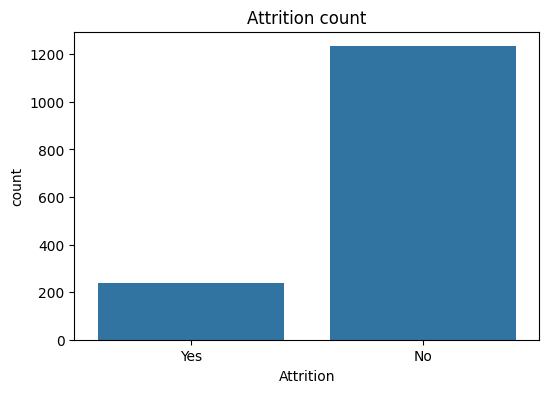

In [ ]:
# Count plot for attrition
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Attrition')
plt.title('Attrition count')
plt.show()

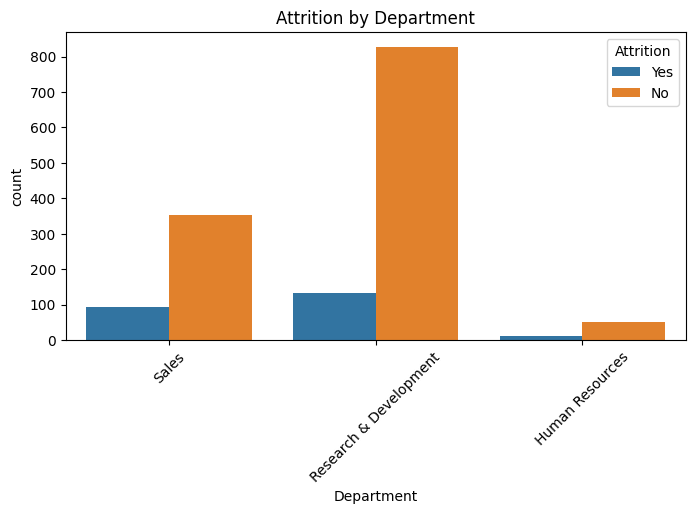

In [ ]:
# Attrition by Department
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Department', hue='Attrition')
plt.title('Attrition by Department')
plt.xticks(rotation=45)
plt.show()

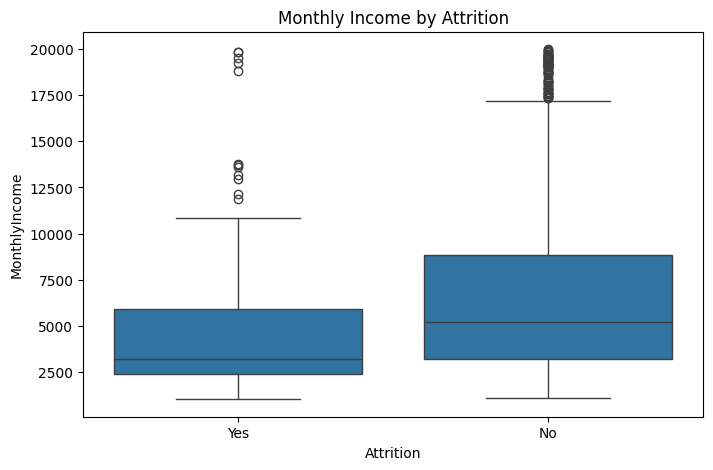

In [ ]:
# Boxplot: MonthlyIncome vs Attrition
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Attrition', y='MonthlyIncome')
plt.title('Monthly Income by Attrition')
plt.show()

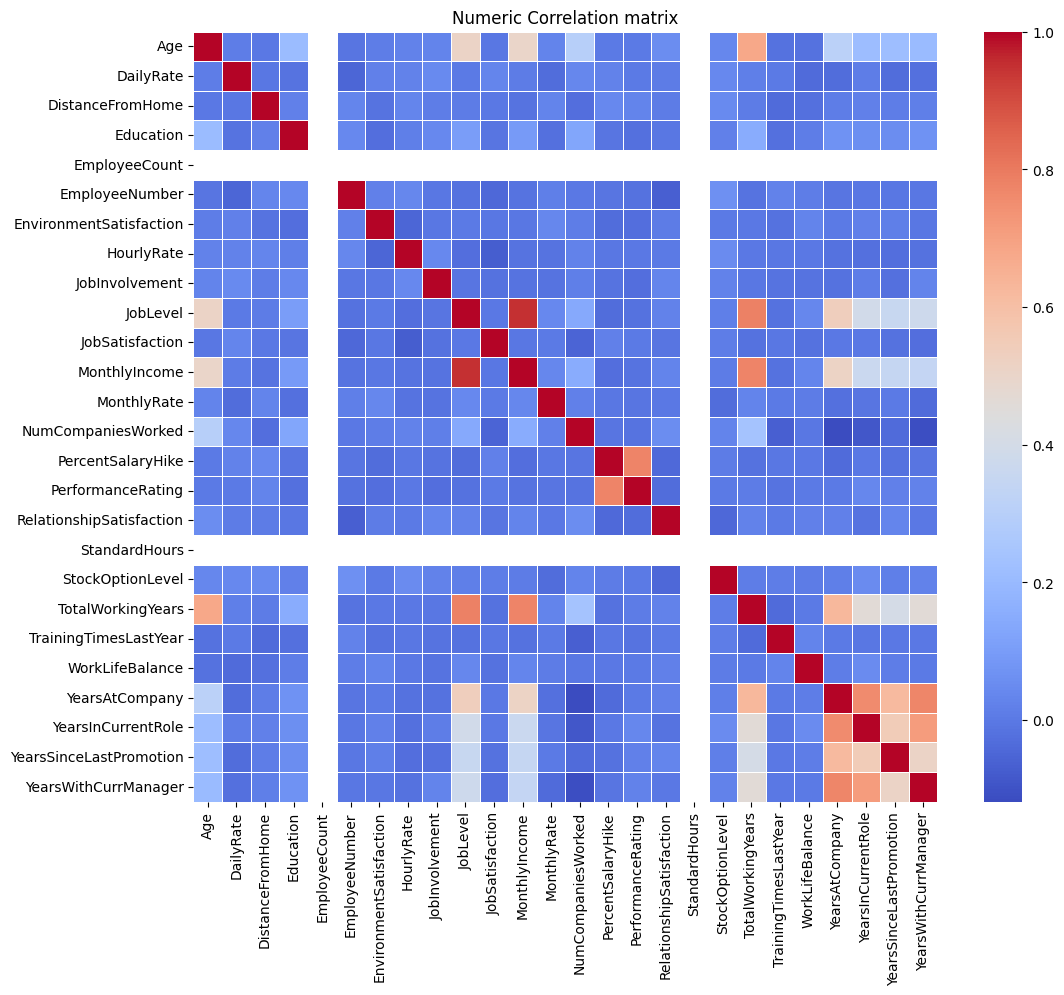

In [ ]:
# Correlation heatmap (numeric features)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,10))
cor = df[num_cols].corr()
sns.heatmap(cor, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Numeric Correlation matrix')
plt.show()

In [ ]:
# Attrition rate by JobRole (descending)
role_table = (df.groupby('JobRole')['Attrition'].apply(lambda s: (s=='Yes').mean()).sort_values(ascending=False).reset_index(name='AttritionRate'))
role_table.head(10)

,JobRole,AttritionRate
0,Sales Representative,0.397590
1,Laboratory Technician,0.239382
2,Human Resources,0.230769
3,Sales Executive,0.174847
4,Research Scientist,0.160959
5,Manufacturing Director,0.068966
6,Healthcare Representative,0.068702
7,Manager,0.049020
8,Research Director,0.025000


In [49]:
# ----------------------
# Basic preprocessing & feature engineering
# ----------------------
# Ensure Attrition flag
if df['Attrition'].dtype == object:
    df['Attrition_flag'] = df['Attrition'].map({'Yes':1, 'No':0})
else:
    df['Attrition_flag'] = df['Attrition']


# Salary band (terciles) — MonthlyIncome preferred
if 'MonthlyIncome' in df.columns:
    df['SalaryBand'] = pd.qcut(df['MonthlyIncome'], q=3, labels=['Low','Medium','High'])
else:
    df['SalaryBand'] = 'Unknown'
# Recently promoted
if 'YearsSinceLastPromotion' in df.columns:
    df['RecentlyPromoted'] = np.where(df['YearsSinceLastPromotion']<=2, 'Yes', 'No')
else:
    df['RecentlyPromoted'] = 'Unknown'
# Convert some logical columns if present
if 'OverTime' in df.columns:
    df['OverTime_flag'] = df['OverTime'].map({'Yes':1, 'No':0})


# A small list of candidate features that are often useful
candidate_features = [
    'Age','MonthlyIncome','DistanceFromHome','TotalWorkingYears','YearsAtCompany',
    'YearsSinceLastPromotion','NumCompaniesWorked','JobLevel','JobSatisfaction',
    'EnvironmentSatisfaction','WorkLifeBalance','OverTime'
]
# Keep only existing ones
features = [c for c in candidate_features if c in df.columns]
print('Features used:', features)


# For modelling, drop rows with missing target
df_model = df.dropna(subset=['Attrition_flag']).copy()
X = df_model[features].copy()
y = df_model['Attrition_flag']


# Identify column types
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

Features used: ['Age', 'MonthlyIncome', 'DistanceFromHome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsSinceLastPromotion', 'NumCompaniesWorked', 'JobLevel', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'OverTime']


In [50]:
# ----------------------
# EDA summaries (export simple CSVs)
# ----------------------
overall_attrition = y.mean()
print(f'Overall attrition rate: {overall_attrition:.3%}')


dept_table = df.groupby('Department')['Attrition_flag'].agg(['mean','count']).reset_index().rename(columns={'mean':'attrition_rate','count':'n'})
dept_table.to_csv(OUTPUT_DIR / 'attrition_by_department.csv', index=False)


job_table = df.groupby('JobRole')['Attrition_flag'].agg(['mean','count']).reset_index().rename(columns={'mean':'attrition_rate','count':'n'})
job_table.to_csv(OUTPUT_DIR / 'attrition_by_jobrole.csv', index=False)


salary_table = df.groupby('SalaryBand')['Attrition_flag'].agg(['mean','count']).reset_index().rename(columns={'mean':'attrition_rate','count':'n'})
salary_table.to_csv(OUTPUT_DIR / 'attrition_by_salaryband.csv', index=False)


promo_table = df.groupby('RecentlyPromoted')['Attrition_flag'].agg(['mean','count']).reset_index().rename(columns={'mean':'attrition_rate','count':'n'})
promo_table.to_csv(OUTPUT_DIR / 'attrition_by_promotion.csv', index=False)

Overall attrition rate: 16.122%


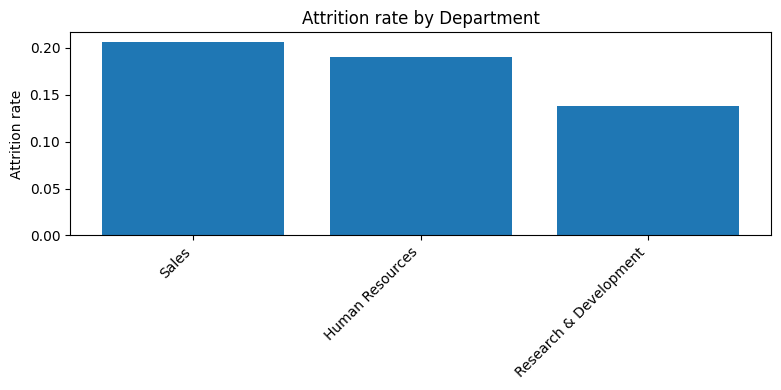

In [51]:
# ----------------------
# Quick plots
# ----------------------
plt.figure(figsize=(8,4))
dept_sorted = dept_table.sort_values('attrition_rate', ascending=False)
plt.bar(dept_sorted['Department'].astype(str), dept_sorted['attrition_rate'])
plt.xticks(rotation=45, ha='right')
plt.title('Attrition rate by Department')
plt.ylabel('Attrition rate')
plt.tight_layout()
plt.show()

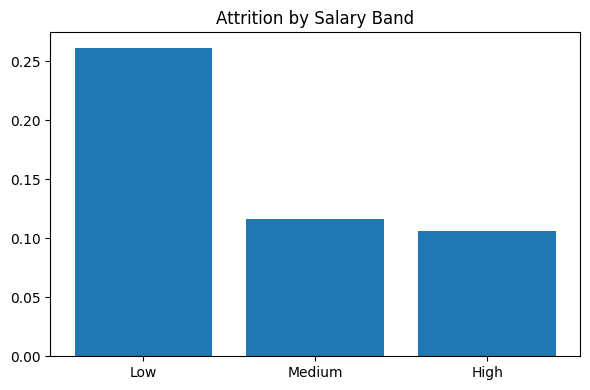

In [52]:
# Salary band plot
plt.figure(figsize=(6,4))
plt.bar(salary_table['SalaryBand'].astype(str), salary_table['attrition_rate'])
plt.title('Attrition by Salary Band')
plt.tight_layout()
plt.show()

In [53]:
# ----------------------
# Model training pipeline
# ----------------------
preprocessor = ColumnTransformer(transformers=[
('num', StandardScaler(), num_cols),
('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])


clf = Pipeline([
('pre', preprocessor),
('clf', RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, class_weight='balanced'))
])


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=RANDOM_STATE)
print('Train/test sizes:', X_train.shape[0], X_test.shape[0])


clf.fit(X_train, y_train)


# Predict & evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]


print('\nClassification report:\n')
print(classification_report(y_test, y_pred, digits=3))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))


# Save model
joblib.dump(clf, OUTPUT_DIR / 'trained_model.joblib')
print('Saved trained model to', OUTPUT_DIR / 'trained_model.joblib')

Train/test sizes: 1102 368

Classification report:

              precision    recall  f1-score   support

           0      0.852     0.951     0.899       309
           1      0.348     0.136     0.195        59

    accuracy                          0.821       368
   macro avg      0.600     0.544     0.547       368
weighted avg      0.771     0.821     0.786       368

ROC AUC: 0.767374252646591
Confusion matrix:
 [[294  15]
 [ 51   8]]
Saved trained model to outputs/trained_model.joblib


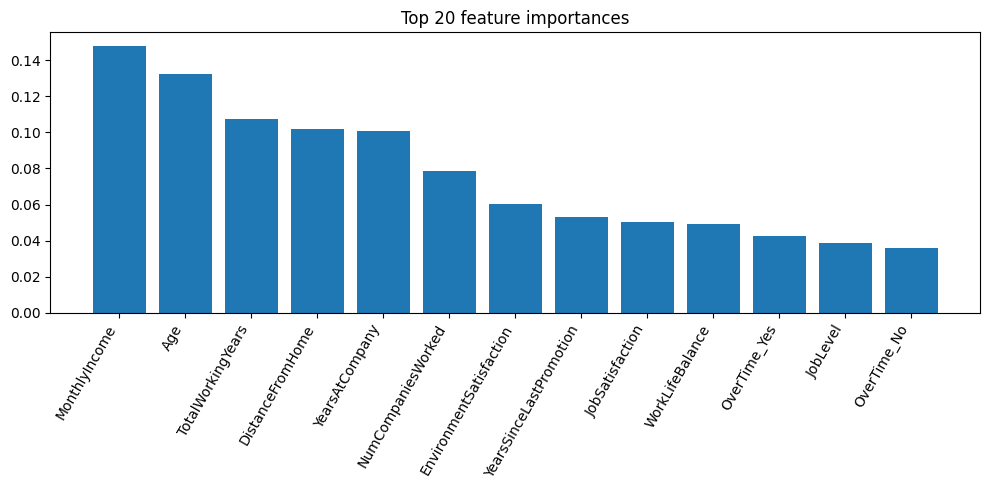

In [54]:
# ----------------------
# Feature importance (map back to feature names)
# ----------------------
# Recover feature names after ColumnTransformer
num_feature_names = num_cols
cat_feature_names = []
if cat_cols:
    ohe = clf.named_steps['pre'].named_transformers_['cat']
    try:
        cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
    except Exception:
        # fallback
        cat_feature_names = []


all_feature_names = num_feature_names + cat_feature_names
importances = clf.named_steps['clf'].feature_importances_
fi = pd.DataFrame({'feature': all_feature_names, 'importance': importances}).sort_values('importance', ascending=False)
fi.to_csv(OUTPUT_DIR / 'feature_importances.csv', index=False)


# Plot top 20
fi_head = fi.head(20)
plt.figure(figsize=(10,5))
plt.bar(fi_head['feature'].astype(str), fi_head['importance'])
plt.xticks(rotation=60, ha='right')
plt.title('Top 20 feature importances')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importances.png')
plt.show()

In [58]:
# -------------------
# 4. SHAP Analysis
# -------------------
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

print("Computing SHAP values — this may take a moment...")

# Transform training data
X_trans = clf.named_steps['pre'].transform(X_train)

# Get feature names
ohe = clf.named_steps['pre'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
all_feature_names = num_cols + cat_feature_names

# TreeExplainer on RandomForest
rf_model = clf.named_steps['clf']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_trans)

Computing SHAP values — this may take a moment...


In [60]:
# -------------------
# 5. Global SHAP summary plot
# -------------------
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

print("Computing SHAP values — this may take a moment...")

# Transform training data
X_train_trans = clf.named_steps['pre'].transform(X_train)
# Transform test data
X_test_trans = clf.named_steps['pre'].transform(X_test)


# Get feature names
ohe = clf.named_steps['pre'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
all_feature_names = num_cols + cat_feature_names

# TreeExplainer on RandomForest
rf_model = clf.named_steps['clf']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train_trans)

# -------------------
# 5. Global SHAP summary plot
# -------------------
# shap_values is a list for classification; index 1 corresponds to positive class
try:
    shap.summary_plot(shap_values[1], X_test_trans, feature_names=all_feature_names, show=False)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "shap_summary.png")
    plt.close()
    print("Saved global SHAP summary plot to outputs/shap_summary.png")
except Exception as e:
    print('SHAP plotting failed:', e)

Computing SHAP values — this may take a moment...
SHAP plotting failed: The shape of the shap_values matrix does not match the shape of the provided data matrix.
